# REMB Production Algorithm - Final Reliable Version

This notebook combines the **robust and verified algorithms** from `Bản_sao_của_algo (1).ipynb` with the **file upload and DXF export capabilities** from `REMB_Production_Complete.ipynb`.

**Features:**
- **Reliable Core Logic:** Uses the specific Voronoi and OR-Tools implementation that has been tested and confirmed working.
- **Input Flexibility:** Upload DWG/DXF files or generate a random site for testing.
- **Output Capability:** Exports results to DXF (CAD) and JSON formats.
- **Infrastructure Planning:** Includes electrical loop networks and drainage flow analysis.

In [1]:
pip install shapely matplotlib networkx ortools scikit-learn scipy numpy ezdxf


[notice] A new release of pip is available: 23.2.1 -> 25.3
[notice] To update, run: pip install --upgrade pip
Note: you may need to restart the kernel to use updated packages.


In [2]:
# Install LibreDWG for DWG conversion (Linux/Colab)
import platform
if platform.system() == 'Linux':
    !apt-get update -qq && apt-get install -y -qq libredwg-tools
    print("✅ LibreDWG installed for DWG conversion")

In [3]:
# 2. IMPORTS & CONFIGURATION
import numpy as np
import matplotlib.pyplot as plt
from shapely.geometry import Polygon, Point, MultiPolygon, LineString, MultiLineString
from shapely.ops import unary_union, voronoi_diagram
from shapely import affinity
import networkx as nx
from ortools.sat.python import cp_model
from sklearn.cluster import KMeans
from scipy.spatial import Voronoi
import random, math, os, json, subprocess
from datetime import datetime

# ==========================================
# CẤU HÌNH TIÊU CHUẨN KCN (PRODUCTION CONFIG)
# (Taken from Bản_sao_của_algo (1).ipynb)
# ==========================================

# --- A. Giao thông & Quy hoạch ---
ROAD_MAIN_WIDTH = 30.0      # Đường trục chính (m) - Xe container tránh nhau thoải mái
ROAD_INTERNAL_WIDTH = 15.0  # Đường nội bộ (m)
SIDEWALK_WIDTH = 4.0        # Vỉa hè mỗi bên (m) - Chứa hào kỹ thuật
TURNING_RADIUS = 15.0       # Bán kính cua xe Container (m) - Vạt góc ngã tư

# --- B. Đất đai & Phân khu chức năng ---
SERVICE_AREA_RATIO = 0.10   # 10% đất dành cho Hạ tầng (Nhà điều hành, XLNT, bãi xe)
MIN_BLOCK_AREA = 5000       # Diện tích block tối thiểu để chia lô (m2)

# --- C. Pháp lý & Xây dựng (TCVN) ---
SETBACK_DISTANCE = 6.0      # Chỉ giới xây dựng lùi vào so với chỉ giới đường đỏ (m)
FIRE_SAFETY_GAP = 4.0       # Khoảng cách PCCC giữa các nhà xưởng (nếu cần)

# --- D. Chia lô (OR-Tools) ---
MIN_LOT_WIDTH = 20.0        # Mặt tiền tối thiểu lô công nghiệp
MAX_LOT_WIDTH = 80.0
TARGET_LOT_WIDTH = 40.0
SOLVER_TIME_LIMIT = 2     # [QUAN TRỌNG] Giới hạn 0.5s mỗi block để tránh treo máy

# --- E. Hạ tầng kỹ thuật ---
TRANSFORMER_RADIUS = 300    # Bán kính phục vụ hiệu quả của 1 trạm biến áp (m)

print("✅ Configuration loaded successfully")

✅ Configuration loaded successfully


In [4]:
# 3. HELPER FUNCTIONS (DWG/DXF)

def convert_dwg_to_dxf(dwg_path, output_path=None):
    """Convert DWG to DXF using LibreDWG."""
    if output_path is None:
        output_path = os.path.splitext(dwg_path)[0] + ".dxf"

    try:
        result = subprocess.run(["dwg2dxf", "-o", output_path, dwg_path],
                                capture_output=True, text=True, timeout=60)
        if result.returncode == 0 and os.path.exists(output_path):
            print(f"✅ DWG converted: {output_path}")
            return output_path
    except:
        pass

    print(f"⚠️ DWG conversion not available. Please convert {dwg_path} to DXF manually.")
    return None

def load_boundary_from_dxf(dxf_path):
    """Load cadastral boundary from DXF file"""
    try:
        import ezdxf
        doc = ezdxf.readfile(dxf_path)
        msp = doc.modelspace()
        largest = None
        max_area = 0
        for entity in msp:
            if entity.dxftype() == 'LWPOLYLINE' and entity.is_closed:
                pts = list(entity.get_points(format='xy'))
                if len(pts) >= 3:
                    poly = Polygon(pts)
                    if poly.is_valid and poly.area > max_area:
                        max_area = poly.area
                        largest = poly
        if largest:
            print(f"✅ Boundary loaded: {largest.area/10000:.2f} ha")
            return largest, doc
    except Exception as e:
        print(f"❌ Error: {e}")
    return None, None

def create_random_site():
    # Tạo một đa giác ngẫu nhiên đại diện cho KCN (~50 ha)
    angles = np.sort(np.random.rand(8) * 2 * np.pi)
    radii = 400 + np.random.rand(8) * 200
    points = np.c_[radii * np.cos(angles), radii * np.sin(angles)]
    site = Polygon(points)
    return site

def get_elevation(x, y):
    # Hàm giả lập địa hình: Nghiêng từ Tây Bắc xuống Đông Nam
    # z = 100 - 0.05x - 0.03y (ví dụ)
    return 50.0 - (x * 0.02) - (y * 0.03)

print("✅ Helper functions ready")

✅ Helper functions ready


💻 Phát hiện môi trường Local.
📁 Đang mở cửa sổ chọn file...
✅ DXF loaded: /Users/nxc/Downloads/Lot Plan Bel air Technical Description.dxf
✅ Boundary loaded: 60264.00 ha
Site Area: 60264.00 ha


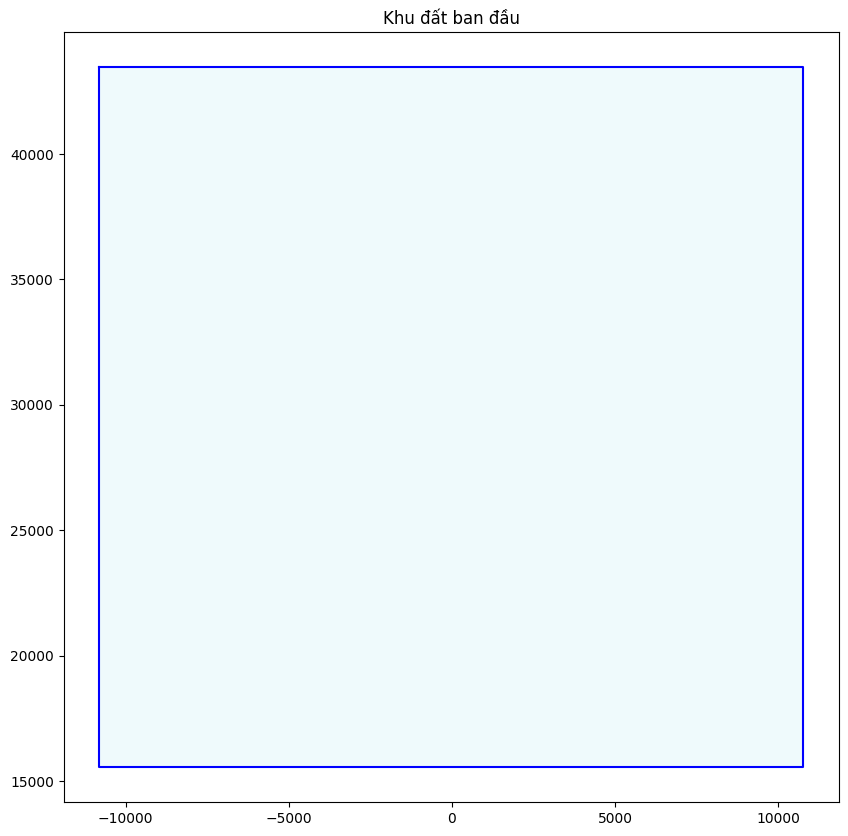

In [5]:
import os
import sys
import matplotlib.pyplot as plt

# Giả định hàm convert và load đã được định nghĩa ở các bước trước
# from your_module import convert_dwg_to_dxf, load_boundary_from_dxf, create_random_site

# 4. INPUT HANDLING: UPLOAD OR RANDOM SITE

DXF_PATH = None
original_doc = None

def select_file_local():
    """Hàm mở cửa sổ chọn file khi chạy Local"""
    try:
        import tkinter as tk
        from tkinter import filedialog
        
        # Tạo cửa sổ gốc nhưng ẩn đi
        root = tk.Tk()
        root.withdraw()
        # Cố gắng đưa cửa sổ lên trên cùng
        root.call('wm', 'attributes', '.', '-topmost', True)
        
        print("📁 Đang mở cửa sổ chọn file...")
        file_path = filedialog.askopenfilename(
            title="Chọn file DWG hoặc DXF",
            filetypes=[("CAD Files", "*.dwg *.dxf"), ("All Files", "*.*")]
        )
        root.destroy() # Đóng cửa sổ sau khi chọn
        return file_path
    except Exception as e:
        print(f"⚠️ Không thể mở cửa sổ chọn file: {e}")
        return None

try:
    # 1. Kiểm tra xem có phải đang chạy trên Google Colab không
    import google.colab
    IN_COLAB = True
except ImportError:
    IN_COLAB = False

# XỬ LÝ UPLOAD / CHỌN FILE
if IN_COLAB:
    # --- Logic cho Google Colab ---
    try:
        from google.colab import files
        print("📁 Upload file DWG hoặc DXF của bạn (Optional):")
        uploaded = files.upload()
        
        # Lấy file cuối cùng được upload
        if uploaded:
            filename = list(uploaded.keys())[0]
            if filename.lower().endswith('.dwg'):
                print(f"🔄 Converting DWG: {filename}")
                DXF_PATH = convert_dwg_to_dxf(filename)
            elif filename.lower().endswith('.dxf'):
                DXF_PATH = filename
                print(f"✅ DXF loaded: {filename}")
            else:
                print(f"⚠️ Unsupported format: {filename}")
        else:
            print("ℹ️ Không có file nào được chọn.")
    except Exception as e:
        print(f"⚠️ Lỗi khi upload Colab: {e}")

else:
    # --- Logic cho Local (Jupyter / VS Code) ---
    print("💻 Phát hiện môi trường Local.")
    # Hỏi người dùng có muốn chọn file không
    choice = input("Bạn có muốn chọn file DWG/DXF không? (y/n): ").strip().lower()
    
    if choice == 'y':
        selected_path = select_file_local()
        if selected_path:
            filename = os.path.basename(selected_path)
            # Copy hoặc xử lý file từ đường dẫn đã chọn
            if filename.lower().endswith('.dwg'):
                print(f"🔄 Converting DWG: {selected_path}")
                # Lưu ý: Hàm convert cần hỗ trợ đường dẫn đầy đủ
                DXF_PATH = convert_dwg_to_dxf(selected_path) 
            elif filename.lower().endswith('.dxf'):
                DXF_PATH = selected_path
                print(f"✅ DXF loaded: {selected_path}")
            else:
                print(f"⚠️ File không được hỗ trợ: {filename}")
        else:
            print("ℹ️ Đã hủy chọn file.")
    else:
        print("ℹ️ Bỏ qua chọn file. Sẽ dùng dữ liệu ngẫu nhiên.")

# --- PHẦN XỬ LÝ CHUNG (LOAD SITE) ---

# Load or create site
if DXF_PATH and os.path.exists(DXF_PATH):
    try:
        site_polygon, original_doc = load_boundary_from_dxf(DXF_PATH)
        if site_polygon is None:
            print("⚠️ Không đọc được boundary từ file, tạo ngẫu nhiên.")
            site_polygon = create_random_site()
    except Exception as e:
        print(f"⚠️ Lỗi khi đọc file DXF: {e}. Tạo ngẫu nhiên.")
        site_polygon = create_random_site()
else:
    site_polygon = create_random_site()
    print("ℹ️ Using random site")

minx, miny, maxx, maxy = site_polygon.bounds
print(f"Site Area: {site_polygon.area/10000:.2f} ha")

# Plot site
fig, ax = plt.subplots(figsize=(10, 10))
x, y = site_polygon.exterior.xy
ax.fill(x, y, color='#e0f7fa', alpha=0.5, label='Ranh giới KCN')
ax.plot(x, y, color='blue')
ax.set_title("Khu đất ban đầu")
plt.show()

In [6]:
# 5. PHASE 1: ROAD NETWORK GENERATION (Reliable Logic)
from shapely.geometry import GeometryCollection

def generate_road_network(site, num_seeds=15):
    # 1. Tạo hạt Voronoi để chia mạng lưới đường
    minx, miny, maxx, maxy = site.bounds
    seeds = []
    for _ in range(num_seeds):
        seeds.append(Point(random.uniform(minx, maxx), random.uniform(miny, maxy)))

    # Tạo Voronoi Diagram
    # buffer(100) để đảm bảo các điểm nằm trong vùng tính toán
    regions = voronoi_diagram(MultiPolygon([site.buffer(100)]), envelope=site.buffer(200))

    # 2. Lấy cạnh của Voronoi làm tim đường
    edges = []

    # --- [FIX LỖI HERE] Xử lý GeometryCollection / MultiPolygon ---
    if hasattr(regions, 'geoms'):
        # Nếu là tập hợp (Collection), lặp qua .geoms
        for region in regions.geoms:
            if region.geom_type == 'Polygon':
                edges.append(region.exterior)
    elif regions.geom_type == 'Polygon':
        # Nếu chỉ có 1 Polygon duy nhất
        edges.append(regions.exterior)

    # Phân loại đường: Trục chính vs Nội bộ
    center = site.centroid
    road_polys = []

    # Hack nhẹ: Union các lines lại để xử lý chung
    all_lines = []
    for geom in edges:
        all_lines.append(geom)

    merged_lines = unary_union(all_lines)

    # Chuẩn hóa thành list các LineString đơn lẻ để duyệt
    lines_to_process = []
    if hasattr(merged_lines, 'geoms'):
        lines_to_process = list(merged_lines.geoms)
    else:
        lines_to_process = [merged_lines]

    for line in lines_to_process:
        if not isinstance(line, (LineString, MultiLineString)):
            continue

        # Heuristic: Nếu đường đi qua gần tâm hoặc rất dài -> Trục chính
        dist_to_center = line.distance(center)
        if dist_to_center < 100 or line.length > 400:
            # Trục chính: Rộng + Vỉa hè
            width = ROAD_MAIN_WIDTH + 2 * SIDEWALK_WIDTH
            road_polys.append(line.buffer(width / 2, cap_style=2, join_style=2))
        else:
            # Nội bộ: Hẹp hơn
            width = ROAD_INTERNAL_WIDTH + 2 * SIDEWALK_WIDTH
            road_polys.append(line.buffer(width / 2, cap_style=2, join_style=2))

    # Hợp nhất mạng lưới đường thành 1 khối polygon
    if not road_polys:
        # Trường hợp hiếm không tạo được đường nào -> trả về danh sách rỗng để tránh lỗi
        return [], [], Polygon()

    network_poly = unary_union(road_polys)

    # 3. Xử lý Vạt góc (Turning Radius) tại ngã tư
    # Kỹ thuật: Buffer dương rồi buffer âm (Rounding corners) hoặc ngược lại
    # Ở đây dùng buffer dương (đã làm ở bước trên) -> buffer âm một chút để làm mượt nếu cần,
    # hoặc dùng kỹ thuật buffer(R).buffer(-R) để bo tròn góc nhọn giao nhau.
    smooth_network = network_poly.buffer(TURNING_RADIUS, join_style=1).buffer(-TURNING_RADIUS, join_style=1)

    # Cắt đất thành các Block (Lấy đất gốc trừ đi đường)
    blocks_rough = site.difference(smooth_network)

    service_blocks = []
    commercial_blocks = []

    # Chuẩn hóa danh sách block candidates
    candidates = []
    if hasattr(blocks_rough, 'geoms'):
        candidates = list(blocks_rough.geoms)
    elif blocks_rough.geom_type == 'Polygon':
        candidates = [blocks_rough]

    # 4. Phân loại đất (Dành đất cho Hạ tầng)
    # Sắp xếp block theo cao độ (thấp nhất ưu tiên làm XLNT)
    candidates.sort(key=lambda b: get_elevation(b.centroid.x, b.centroid.y))

    total_area = sum([b.area for b in candidates])
    current_service_area = 0

    # Block thấp nhất -> Trạm xử lý nước thải (WWTP)
    if candidates:
        wwtp = candidates.pop(0)
        service_blocks.append({'geom': wwtp, 'type': 'XLNT (Thấp nhất)'})
        current_service_area += wwtp.area

    # Các block còn lại
    for b in candidates:
        # Nếu block quá nhỏ hoặc hình dáng méo mó hoặc cần thêm đất dịch vụ -> Dịch vụ
        # (Heuristic: diện tích < 1.5 lần min hoặc chưa đủ chỉ tiêu 10%)
        if (current_service_area < total_area * SERVICE_AREA_RATIO) or (b.area < MIN_BLOCK_AREA):
             service_blocks.append({'geom': b, 'type': 'Điều hành/Bãi xe'})
             current_service_area += b.area
        else:
            commercial_blocks.append(b)

    return commercial_blocks, service_blocks, smooth_network

# Chạy hàm
blocks, service_blocks, road_network = generate_road_network(site_polygon)
print(f"✅ Số block thương phẩm: {len(blocks)}")
print(f"✅ Số block hạ tầng: {len(service_blocks)}")

✅ Số block thương phẩm: 6
✅ Số block hạ tầng: 2


In [7]:
# 6. PHASE 2: LOT SUBDIVISION (Reliable Logic)

def solve_subdivision_with_timelimit(total_len, min_w, max_w, target_w):
    """Giải thuật toán chia lô với giới hạn thời gian"""
    model = cp_model.CpModel()
    max_lots = int(total_len // min_w) + 2

    widths = []
    is_active = []
    diffs = []

    for i in range(max_lots):
        w = model.NewIntVar(0, int(max_w * 10), f'w_{i}')
        active = model.NewBoolVar(f'active_{i}')

        model.Add(w >= int(min_w * 10)).OnlyEnforceIf(active)
        model.Add(w <= int(max_w * 10)).OnlyEnforceIf(active)
        model.Add(w == 0).OnlyEnforceIf(active.Not())

        # Cố gắng đạt kích thước Target
        diff = model.NewIntVar(0, int(max_w * 10), f'diff_{i}')
        model.Add(diff >= w - int(target_w * 10)).OnlyEnforceIf(active)
        model.Add(diff >= int(target_w * 10) - w).OnlyEnforceIf(active)
        model.Add(diff == 0).OnlyEnforceIf(active.Not())

        widths.append(w)
        is_active.append(active)
        diffs.append(diff)

    total_w_var = model.NewIntVar(0, int(total_len * 10), 'total_w')
    model.Add(total_w_var == sum(widths))

    # Maximize diện tích lấp đầy & Minimize độ lệch chuẩn
    model.Maximize(total_w_var * 100 - sum(diffs))

    solver = cp_model.CpSolver()
    # --- [TIME LIMIT FIX] ---
    solver.parameters.max_time_in_seconds = SOLVER_TIME_LIMIT

    status = solver.Solve(model)

    results = []
    if status in [cp_model.OPTIMAL, cp_model.FEASIBLE]:
        for i in range(max_lots):
            if solver.Value(is_active[i]):
                results.append(solver.Value(widths[i]) / 10.0)
    return results

def calculate_legal_params(lot_polygon):
    """Tính mật độ xây dựng & Chỉ giới"""
    # 1. Chỉ giới xây dựng (Setback)
    buildable_area = lot_polygon.buffer(-SETBACK_DISTANCE)

    if buildable_area.is_empty:
        return None, 0, 0

    # 2. Mật độ xây dựng (Quy chuẩn VN - Ví dụ đơn giản hóa)
    # Diện tích càng lớn, mật độ cho phép càng giảm
    area_m2 = lot_polygon.area
    if area_m2 < 3000: density = 0.70  # 70%
    elif area_m2 < 10000: density = 0.65 # 65%
    else: density = 0.60 # 60%

    max_build_area = area_m2 * density

    return buildable_area, density * 100, max_build_area

final_lots = []
buildable_footprints = []

print("Đang chia lô...")
for idx, block in enumerate(blocks):
    rect = block.minimum_rotated_rectangle
    x, y = rect.exterior.coords.xy
    edge_lengths = [Point(x[i], y[i]).distance(Point(x[i+1], y[i+1])) for i in range(4)]
    max_idx = np.argmax(edge_lengths)
    total_len = edge_lengths[max_idx]

    # Gọi Solver (Time limited)
    widths = solve_subdivision_with_timelimit(total_len, MIN_LOT_WIDTH, MAX_LOT_WIDTH, TARGET_LOT_WIDTH)

    # Cắt hình học (Logic vector như cũ)
    p0 = np.array([x[max_idx], y[max_idx]])
    p1 = np.array([x[(max_idx+1)%4], y[(max_idx+1)%4]])
    vec = p1 - p0
    vec_len = np.linalg.norm(vec)
    if vec_len == 0: continue
    unit_vec = vec / vec_len
    ortho = np.array([-unit_vec[1], unit_vec[0]])

    curr = 0
    for w in widths:
        start = p0 + unit_vec * curr
        end = p0 + unit_vec * (curr + w)
        cutter = Polygon([start - ortho*500, end - ortho*500, end + ortho*500, start + ortho*500])
        lot = block.intersection(cutter)

        if not lot.is_empty and lot.area > 500: # Lọc lô vụn
             if isinstance(lot, MultiPolygon):
                 for g in lot.geoms: final_lots.append(g)
             else:
                 final_lots.append(lot)
        curr += w

# Tính toán tham số pháp lý cho từng lô
processed_lots = []
for lot in final_lots:
    b_zone, density, max_area = calculate_legal_params(lot)
    if b_zone is not None:
        processed_lots.append({
            'geom': lot,
            'buildable': b_zone,
            'density': density,
            'max_area': max_area
        })

print(f"✅ Hoàn tất chia {len(processed_lots)} lô đất thương phẩm.")

Đang chia lô...
✅ Hoàn tất chia 824 lô đất thương phẩm.


In [8]:
# 7. PHASE 3: INFRASTRUCTURE (Reliable Logic)

# --- A. MẠNG LƯỚI ĐIỆN MẠCH VÒNG (LOOP NETWORK) ---
def create_loop_network(lots):
    centroids = [l['geom'].centroid for l in lots]
    G = nx.Graph()

    # Thêm nodes
    for i, p in enumerate(centroids):
        G.add_node(i, pos=(p.x, p.y))

    # Thêm cạnh (dựa trên khoảng cách)
    for i in range(len(centroids)):
        for j in range(i+1, len(centroids)):
            dist = centroids[i].distance(centroids[j])
            if dist < 150: # Chỉ nối các lô gần nhau
                G.add_edge(i, j, weight=dist)

    # 1. Tạo MST (Cây - Minimum Spanning Tree)
    # Kiểm tra đồ thị có liên thông không, nếu không thì nối các cụm
    if not nx.is_connected(G):
        # Fallback đơn giản: nối tất cả vào node 0 (hoặc xử lý phức tạp hơn)
        # Ở đây ta bỏ qua các node cô lập để tránh lỗi MST
        components = list(nx.connected_components(G))
        largest_comp = max(components, key=len)
        subgraph = G.subgraph(largest_comp).copy()
        mst = nx.minimum_spanning_tree(subgraph)
    else:
        mst = nx.minimum_spanning_tree(G)

    # 2. Tạo Loop (Vòng): Thêm lại 15% số cạnh đã bị loại bỏ để tạo mạch vòng an toàn
    all_edges = sorted(G.edges(data=True), key=lambda x: x[2]['weight'])
    loop_graph = mst.copy()

    added_count = 0
    target_extra = int(len(lots) * 0.15) # Thêm 15% cạnh dư thừa

    for u, v, data in all_edges:
        if not loop_graph.has_edge(u, v):
            try:
                loop_graph.add_edge(u, v, weight=data['weight'])
                added_count += 1
                if added_count >= target_extra: break
            except:
                pass

    return loop_graph

# Kiểm tra nếu có lô đất thì mới chạy
if len(processed_lots) > 0:
    infra_graph = create_loop_network(processed_lots)
else:
    infra_graph = nx.Graph()

# --- B. CLUSTER TRẠM BIẾN ÁP (K-MEANS) ---
if len(processed_lots) > 0:
    lot_coords = np.array([[l['geom'].centroid.x, l['geom'].centroid.y] for l in processed_lots])
    # Ước tính số trạm: 1 trạm phục vụ ~15 lô hoặc bán kính 300m
    num_transformers = max(1, int(len(processed_lots) / 15))

    # KMeans cần ít nhất số sample bằng số cluster
    if len(processed_lots) < num_transformers:
        num_transformers = len(processed_lots)

    kmeans = KMeans(n_clusters=num_transformers, n_init=10).fit(lot_coords)
    transformer_locs = kmeans.cluster_centers_
else:
    transformer_locs = np.array([])

# --- C. THOÁT NƯỚC (GRAVITY FLOW) ---
# Tìm hướng dòng chảy từ mỗi lô về phía trạm XLNT
wwtp_loc = None
for s in service_blocks:
    if "XLNT" in s['type']:
        wwtp_loc = s['geom'].centroid
        break
if wwtp_loc is None: wwtp_loc = site_polygon.centroid # Fallback

flow_arrows = []
for lot in processed_lots:
    c = lot['geom'].centroid
    # Vector hướng về XLNT
    dx = wwtp_loc.x - c.x
    dy = wwtp_loc.y - c.y

    # [FIXED] Dùng **2 (bình phương) thay vì *2 (nhân 2)
    length = math.sqrt(dx**2 + dy**2)

    # Chuẩn hóa vector để vẽ mũi tên ngắn (dài 30m)
    if length > 0:
        flow_arrows.append((c.x, c.y, dx/length*30, dy/length*30))

print("✅ Hoàn tất tính toán hệ thống kỹ thuật (Điện, Nước).")

✅ Hoàn tất tính toán hệ thống kỹ thuật (Điện, Nước).


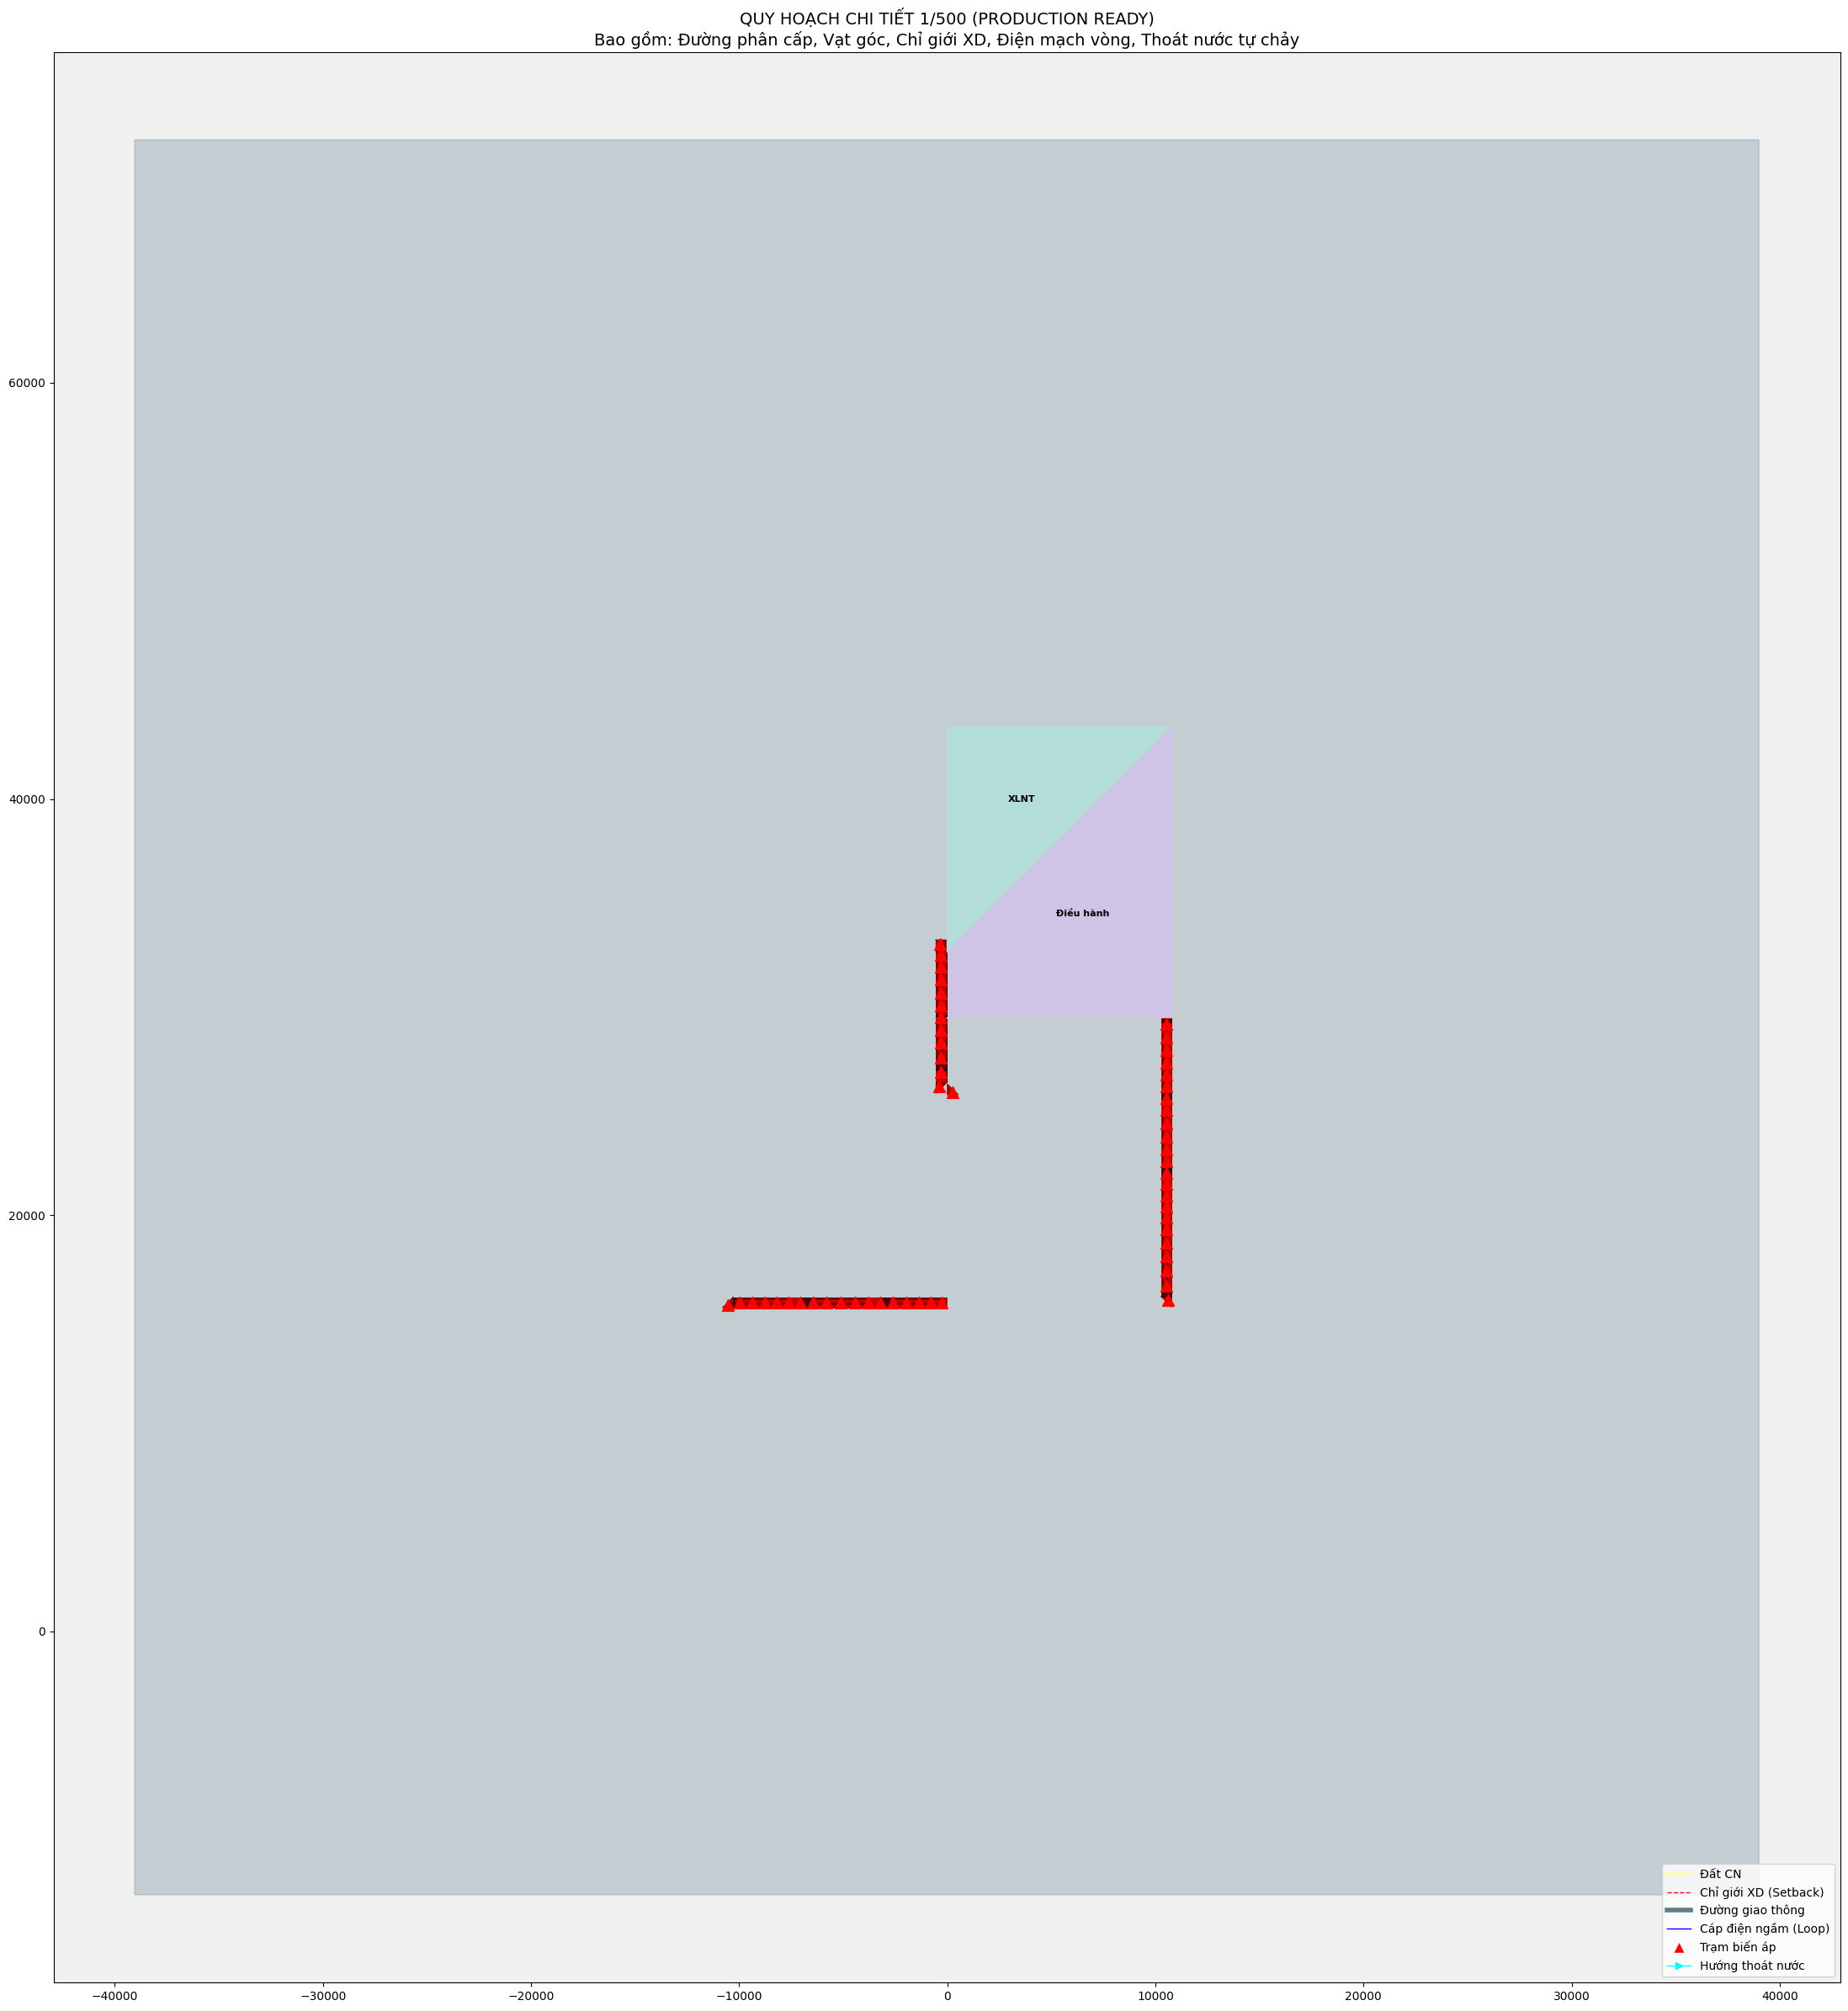

In [9]:
# 8. VISUALIZATION (Reliable Logic)

fig, ax = plt.subplots(figsize=(24, 24)) # Increased size for better visibility
ax.set_aspect('equal')
ax.set_facecolor('#f0f0f0')

# 1. Vẽ Đường & Vỉa hè
for geom in road_network.geoms if isinstance(road_network, MultiPolygon) else [road_network]:
    x, y = geom.exterior.xy
    ax.fill(x, y, color='#607d8b', alpha=0.3, label='Hạ tầng giao thông') # Đường xám

# 2. Vẽ Lô đất thương phẩm & Chỉ giới xây dựng
for lot in processed_lots:
    # Ranh giới lô đất
    x, y = lot['geom'].exterior.xy
    ax.plot(x, y, color='black', linewidth=0.5)
    ax.fill(x, y, color='#fff9c4', alpha=0.5) # Màu vàng đất CN

    # Chỉ giới xây dựng (Setback) - Nét đứt đỏ
    if not lot['buildable'].is_empty:
        if isinstance(lot['buildable'], Polygon):
            bx, by = lot['buildable'].exterior.xy
            ax.plot(bx, by, color='red', linestyle='--', linewidth=0.8, alpha=0.7)
        elif isinstance(lot['buildable'], MultiPolygon):
             for b in lot['buildable'].geoms:
                bx, by = b.exterior.xy
                ax.plot(bx, by, color='red', linestyle='--', linewidth=0.8, alpha=0.7)

# 3. Vẽ Đất Dịch vụ / Kỹ thuật
for s in service_blocks:
    x, y = s['geom'].exterior.xy
    if "XLNT" in s['type']:
        color = '#b2dfdb' # Xanh nước
        label = "XLNT"
    else:
        color = '#d1c4e9' # Tím
        label = "Điều hành"
    ax.fill(x, y, color=color, alpha=0.9)
    ax.text(s['geom'].centroid.x, s['geom'].centroid.y, label, ha='center', fontsize=8, color='black', weight='bold')

# 4. Vẽ Hạ tầng điện (Mạch vòng)
pos = nx.get_node_attributes(infra_graph, 'pos')
# Vẽ cạnh (dây điện ngầm)
for u, v in infra_graph.edges():
    if u in pos and v in pos:
        p1 = pos[u]
        p2 = pos[v]
        ax.plot([p1[0], p2[0]], [p1[1], p2[1]], color='blue', linestyle='-', linewidth=0.5, alpha=0.4)

# 5. Vẽ Trạm biến áp (Cluster centers)
if len(transformer_locs) > 0:
    ax.scatter(transformer_locs[:, 0], transformer_locs[:, 1], c='red', marker='^', s=100, label='Trạm biến áp', zorder=10)

# 6. Vẽ Hướng thoát nước (Mũi tên) - Chỉ vẽ đại diện 1 số mũi tên cho đỡ rối
for i, (fx, fy, dx, dy) in enumerate(flow_arrows):
    if i % 3 == 0: # Lấy mẫu
        ax.arrow(fx, fy, dx, dy, head_width=5, head_length=5, fc='cyan', ec='cyan', alpha=0.6)

# Chú thích
plt.title("QUY HOẠCH CHI TIẾT 1/500 (PRODUCTION READY)\n"
          "Bao gồm: Đường phân cấp, Vạt góc, Chỉ giới XD, Điện mạch vòng, Thoát nước tự chảy", fontsize=14)

# Legend thủ công
from matplotlib.lines import Line2D
custom_lines = [Line2D([0], [0], color='#fff9c4', lw=4),
                Line2D([0], [0], color='red', linestyle='--', lw=1),
                Line2D([0], [0], color='#607d8b', lw=4),
                Line2D([0], [0], color='blue', lw=1),
                Line2D([0], [0], marker='^', color='w', markerfacecolor='red', markersize=10),
                Line2D([0], [0], color='cyan', lw=1, marker='>')]

ax.legend(custom_lines, ['Đất CN', 'Chỉ giới XD (Setback)', 'Đường giao thông', 'Cáp điện ngầm (Loop)', 'Trạm biến áp', 'Hướng thoát nước'], loc='lower right')

plt.tight_layout()
plt.show()

In [ ]:
# 9. EXPORT RESULTS (DXF & JSON)

# --- JSON EXPORT ---
result = {
    "timestamp": datetime.now().isoformat(),
    "site_area_ha": site_polygon.area / 10000,
    "lots": [],
    "service_blocks": [],
    "transformers": []
}

for i, lot in enumerate(processed_lots):
    geom = lot['geom']
    result["lots"].append({
        "id": i + 1,
        "centroid_x": geom.centroid.x,
        "centroid_y": geom.centroid.y,
        "area_m2": geom.area,
        "buildable_area_m2": lot['max_area'],
        "density_percent": lot['density']
    })

for i, sb in enumerate(service_blocks):
    geom = sb['geom']
    result["service_blocks"].append({
        "id": i + 1,
        "type": sb['type'],
        "centroid_x": geom.centroid.x,
        "centroid_y": geom.centroid.y,
        "area_m2": geom.area
    })

for i, t in enumerate(transformer_locs):
    result["transformers"].append({
        "id": i + 1,
        "x": float(t[0]),
        "y": float(t[1]),
        "service_radius": TRANSFORMER_RADIUS
    })

with open('optimization_result.json', 'w') as f:
    json.dump(result, f, indent=2)

print("✅ JSON saved to optimization_result.json")

# --- DXF EXPORT ---
def export_to_dxf(output_path, original_doc=None):
    """Export optimization results to DXF, preserving original data if available"""
    import ezdxf

    # Use original doc or create new
    if original_doc:
        doc = original_doc
        print("✅ Preserving original DXF data")
    else:
        doc = ezdxf.new('R2010')
        print("ℹ️ Creating new DXF file")

    msp = doc.modelspace()

    # Add layers
    layers = {
        'OPTIMIZED_PLOTS': 3,      # Green
        'OPTIMIZED_ROADS': 1,      # Red
        'ANNOTATIONS': 7,          # White
        'INFRASTRUCTURE': 5,       # Blue
    }

    for layer_name, color in layers.items():
        if layer_name not in doc.layers:
            doc.layers.add(layer_name, color=color)

    # Add plots
    plot_count = 0
    for i, lot in enumerate(processed_lots):
        geom = lot['geom']
        if geom.geom_type == 'Polygon':
            points = list(geom.exterior.coords)
            msp.add_lwpolyline(points, close=True, dxfattribs={'layer': 'OPTIMIZED_PLOTS'})

            # Add label
            centroid = geom.centroid
            msp.add_text(
                f"Plot_{i+1}",
                dxfattribs={'layer': 'ANNOTATIONS', 'height': 5, 'insert': (centroid.x, centroid.y)}
            )
            plot_count += 1

    # Add transformers
    for i, t in enumerate(transformer_locs):
        msp.add_circle((float(t[0]), float(t[1])), radius=10, dxfattribs={'layer': 'INFRASTRUCTURE'})
        msp.add_text(
            f"TRF_{i+1}",
            dxfattribs={'layer': 'ANNOTATIONS', 'height': 8, 'insert': (float(t[0]), float(t[1]) + 15)}
        )

    # Add info block
    info_y = maxy + 100
    info_lines = [
        "OPTIMIZATION RESULTS",
        f"Date: {datetime.now().strftime('%Y-%m-%d %H:%M')}",
        f"Plots: {len(processed_lots)}",
    ]
    for line in info_lines:
        msp.add_text(line, dxfattribs={'layer': 'ANNOTATIONS', 'height': 10, 'insert': (minx, info_y)})
        info_y -= 15

    # Save
    doc.saveas(output_path)
    print(f"\n✅ DXF exported: {output_path}")
    print(f"   Plots added: {plot_count}")
    print(f"   Transformers added: {len(transformer_locs)}")

    return output_path

# Export to DXF
export_to_dxf('remb_output.dxf', original_doc)

# --- DOWNLOAD (Colab) ---
try:
    from google.colab import files
    print("📥 Downloading output files...")
    if os.path.exists('optimization_result.json'):
        files.download('optimization_result.json')
    if os.path.exists('remb_output.dxf'):
        files.download('remb_output.dxf')
except ImportError:
    print("ℹ️ Output files are in the current directory.")

✅ JSON saved to optimization_result.json
✅ Preserving original DXF data

✅ DXF exported: remb_output.dxf
   Plots added: 824
   Transformers added: 54
ℹ️ Output files are in the current directory.


: 